# PHY 604: Homework #5 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div style="background-color: powderblue; color: black; padding: 10px;">

1. _Implicit advection_ Consider the linear advection equation:
\begin{equation}
a_t + u a_x = 0
\end{equation}
In class, we saw that an explicit first-order finite-difference upwind
discretization of this resulted in a stable method.  Here we consider
an implicit discretization of this same upwind method--now the
spatial derivative is evaluated at the new time.

<p>**a.** Perform linear stability analysis (as we did in class) and 
show that this method is stable for any choice of Courant number.
</div>

Our discretized equation is:
\begin{equation}
a_i^{n+1} = a_i^n - C (a_i^{n+1} - a_{i-1}^{n+1})
\end{equation}

Introducing a Fourier mode,
\begin{equation}
a_i^n = A^n e^{Ii\theta}
\end{equation}
(where $I = \sqrt{-1}$ is the imaginary unit), we have:
\begin{equation}
A^{n+1}e^{Ii\theta} = A^n e^{Ii\theta} - C (A^{n+1} e^{Ii\theta} - A^{n+1} e^{I(i-1)\theta} )
\end{equation}
Simplifying:
\begin{equation}
\frac{A^{n+1}}{A^n} = \frac{1}{1 + C(1- e^{-I\theta})} = \frac{1}{1 + C - C\cos\theta + I C \sin\theta}
\end{equation}

The magnitude of this is:
\begin{equation}
\left | \frac{A^{n+1}}{A^n} \right |^2 = \left [ 1 + 2C(1+C) (1 - \cos \theta) \right ]^{-1}
\end{equation}
Regardless of the value of $\theta$, we see that 
\begin{equation}
\left | \frac{A^{n+1}}{A^n} \right |^2  \le 1
\end{equation}

Therefore, we are stable for any $C>0$.

<div style="background-color: powderblue; color: black; padding: 10px;">

**b.** Solve this implicit discretization numerically with
periodic boundary conditions.

<p>When you write this out, you will find that you have a coupled linear
system of equations that can be written in a matrix form.  The matrix
is almost tridiagonal, except for a single element in a corner
resulting from the periodicity.  You can use the periodic tridiagonal
solver from a previous homework to solve this (or use a general
matrix solver if you wish).

<p>Make plots of the solution with 64 and 256 grid points with $C = 0.5, 1, 10$.

</div>

To start, here's a class that manages a finite-difference grid.  We'll start counting at index 0, and since this is finite-difference, we'll have points 0 and N-1 on the boundary.  But these are the same point (cause we are periodic), so we only really need to update points 1, ..., N-1

In [2]:
class FDGrid(object):

    def __init__(self, nx, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx

        # python is zero-based.  We are assuming periodic BCs, so
        # points 0 and N-1 are the same.  Set some integer indices to
        # allow us to easily access points 1 through N-1.  Point 0
        # won't be explicitly updated, but rather filled by the BC
        # routine.
        self.ilo = 1
        self.ihi = nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + np.arange(nx)*self.dx

        # storage for the solution
        self.a = np.zeros((nx), dtype=np.float64)
        self.ainit = np.zeros((nx), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx), dtype=np.float64)

    def fill_BCs(self):
        """ we don't explicitly update point 0, since it is identical
            to N-1, so fill it here """
        self.a[0] = self.a[self.ihi]

Our update appears as
$$a_i^{n+1} (1 + C) - C a_{i-1}^{n+1} = a_i^n$$
since we are not updating zone 0, but instead filling it via the boundary conditions to be the same as N-1, our matrix will just have a diagonal of $1+C$ and an lower diagonal of $-C$, with a corner element of $-C$ too, owing to the periodicity.

In [3]:
def evolve(nx, C, u, tmax):

    # create the grid
    g = FDGrid(nx)

    # time info
    dt = C*g.dx/u
    t = 0.0

    # initialize the data -- tophat
    g.a[np.logical_and(g.x >= 0.333, g.x <= 0.666)] = 1.0

    g.ainit[:] = g.a.copy()

    # evolution loop -- we have an N-1 x N-1 matrix, since we are
    # not evolving point 0
    A = np.zeros((g.nx-1, g.nx-1), dtype=np.float64)

    # fill the boundary conditions
    g.fill_BCs()

    while t < tmax:

        # create the matrix

        # loop over rows [ilo,ihi] and construct the matrix.  This will
        # be almost bidiagonal, but with the upper right entry also
        # nonzero.
        for i in range(g.nx-1):
            A[i,i] = 1.0 + C
            A[i,i-1] = -C


        # create the RHS -- this holds all entries except for a[0]
        b = g.a[g.ilo:g.ihi+1]

        # solve the system
        anew = np.linalg.solve(A, b)

        g.a[g.ilo:g.ihi+1] = anew[:]

        g.fill_BCs()

        t += dt

    return g

This driver runs the evolution at a given resolution for a number of different CFL values

In [4]:
def run_and_plot(nx):
    u = 1.0
    tmax = 1.0/u

    CFL = [0.5, 1.0, 10.0]

    for C in CFL:
        g = evolve(nx, C, u, tmax)

        plt.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], label="C = %3.2f" % (C))

    plt.plot(g.x[g.ilo:g.ihi+1], g.ainit[g.ilo:g.ihi+1], ls=":", label="initial conditions")

    plt.title("N = %d" % (nx))
    plt.xlabel("x")

    plt.legend(frameon=False, fontsize="small")

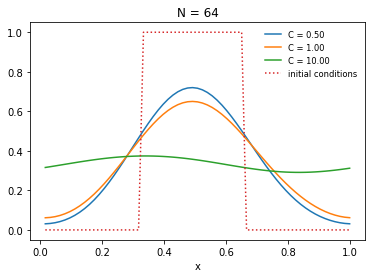

In [5]:
run_and_plot(64)

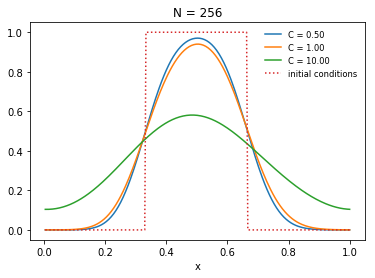

In [6]:
run_and_plot(256)

<div style="background-color: powderblue; color: black; padding: 10px;">
2. In class, we discussed the linear advection equati
on:
\begin{equation}
a_t + [u a]_x = 0
\end{equation}
where $a$ is the advected quantity and $u > 0$ is the velocity.  We've
written this in conservative form, with a flux, $f(a) = ua$.  Here's
we consider a method-of-lines approach to integrating the system.  We
saw that the finite-volume approach begins by integrating our
conservation law over space, giving:
\begin{equation}
\frac{\partial a_i}{\partial t} = -\frac{1}{\Delta x} \left \{ [f(a)]_{i+1/2} - 
[f(a)]_{i-1/2} \right \}
\end{equation}

<p>We will solve this using the method-of-lines approach, using a
2nd-order Runge-Kutta integrator to do the time integration.  To
construct the fluxes, we will use piecewise linear reconstruction in a zone:
![grid](riemann-mol.png)

Here, the cell-averages, $a_i$, are indicated by the dotted lines.  We
do piecewise linear reconstruction to create a slope in each cell (the
red lines) and use the value of these lines on the interface to
evaluate the flux.  Notice that there are two potential states on each
interface---for the $i+1/2$ interface, these are drawn as the blue
$\times$'s.  This is where we use upwinding---for $u>0$, we always take
the left state on the interface.

<p>To solve this using an ODE integrator in time, you will need to
evaluate the righthand side of the above equation (the divergence of the
flux).  The procedure for this is as follows:
  <ul>
      <li>Fill the ghost cells with your boundary conditions.</li>

  <li>Do linear reconstruction in each zone as:
    $$\Delta a_i = \frac{1}{2} (a_{i+1} - a_{i-1})$$ Notice that we do not
    divide by $\Delta x$ in this slope definition.

    You'll need to do this reconstruction in one ghost cell, so you'll
    need 2 ghostcells on each side of the domain in order to compute all
    the needed slopes.</li>

  <li>Construct the interface state on each interface using the slope
    just to the left of the interface:
    $$a_{i+1/2} = a_i + \frac{1}{2} \Delta a_i$$</li>

  <li>Compute the flux through the interface as
    $$[f(a)]_{i+1/2} = u a_{i+1/2}$$</li>
  </ul>


Solve this equation using 2nd-order Runge-Kutta for the time-integration.
This means that you'll do the flux divergence construction outlined above twice
for each timestep.

<p>Pick a value of the Courant number, $C = 0.5$, and work
on a domain $[0,1]$ with periodic boundary conditions.  By choosing
the number of zones, $N$, you can compute the timestep,
$$\Delta t = \frac{C \Delta x}{|u|}$$
    </div>

<div style="background-color: powderblue; color: black; padding: 10px;">

**a.** Solve this for one period with $N = 64$, with the following initial conditions:

  <ul>
    <li>Gaussian: $$a(x, t=0) = 1 + e^{-60 (x - 1/2)^2}$$</li>

    <li>Tophat: $$a(x, t=0) = \begin{cases} 0 & x < 1/3 \\ 1 & 1/3 \le x \le 2/3
      \\ 0 & x > 2/3 \end{cases}$$</li>
  </ul>
      </div>

To start, here's our grid class.  It is similar to the finite-volume one above, except it handles our boundary conditions (with multiple ghost cells).

In [7]:
class FVGrid(object):

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        self.xl = xmin + (np.arange(nx+2*ng)-ng)*self.dx
        self.xr = xmin + (np.arange(nx+2*ng)-ng+1.0)*self.dx

        # storage for the solution
        self.a = self.scratch_array()
        self.ainit = self.scratch_array()

    def period(self, u):
        """ return the period for advection with velocity u """
        return (self.xmax - self.xmin)/u

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all single ghostcell with periodic boundary conditions """

        # left boundary
        for n in range(self.ng):
            atmp[self.ilo-1-n] = atmp[self.ihi-n]

        # right boundary
        for n in range(self.ng):
            atmp[self.ihi+1+n] = atmp[self.ilo+n]

    def init_cond(self, ic):

        if ic == "tophat":
            self.a[np.logical_and(self.x >= 0.333, self.x <= 0.666)] = 1.0
        elif ic == "sine":
            self.a[:] = np.sin(2.0*np.pi*self.x/(self.xmax-self.xmin))
        elif ic == "gaussian":
            self.a[:] = 1.0 + np.exp(-60.0*(self.x - 0.5)**2)

        self.ainit[:] = self.a[:]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

Now, here's the routine that does the flux update as described in the problem

In [8]:
def flux_update(gr, u, a):

    # slope
    da = gr.scratch_array()
    da[gr.ilo-1:gr.ihi+2] = 0.5*(a[gr.ilo:gr.ihi+3] - a[gr.ilo-2:gr.ihi+1])

    # upwinding means that we take the left state always
    aint = gr.scratch_array()
    aint[gr.ilo:gr.ihi+2] = a[gr.ilo-1:gr.ihi+1] + 0.5*da[gr.ilo-1:gr.ihi+1]

    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = u*(aint[gr.ilo:gr.ihi+1] - aint[gr.ilo+1:gr.ihi+2])/gr.dx

    return flux_diff

Finally, here's the main driver that implements RK-2 integration

In [9]:
def mol_update(C, u, nx, num_periods=1, init_cond="gaussian"):

    # create a grid
    gr = FVGrid(nx, ng=2)

    tmax = num_periods*gr.period(u)

    # setup initial conditions
    gr.init_cond(init_cond)

    # compute the timestep
    dt = C*gr.dx/u

    t = 0.0
    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t

        # second-order RK integration
        gr.fill_BCs(gr.a)
        k1 = flux_update(gr, u, gr.a)

        atmp = gr.scratch_array()
        atmp[:] = gr.a[:] + 0.5*dt*k1[:]

        gr.fill_BCs(atmp)
        k2 = flux_update(gr, u, atmp)

        gr.a[:] += dt*k2[:]

        t += dt

    return gr


Here's Gaussian initial conditions

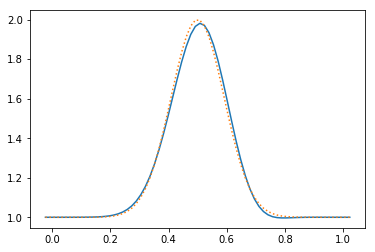

In [10]:
C = 0.5
u = 1.0
nx = 64

gr = mol_update(C, u, nx, num_periods=1.0, init_cond="gaussian")

plt.plot(gr.x, gr.a)
plt.plot(gr.x, gr.ainit, ls=":")

and tophat initial conditions

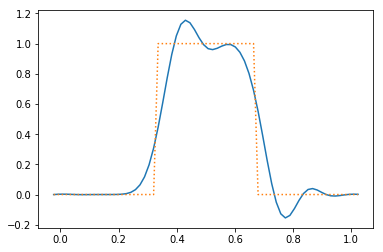

In [11]:
gr = mol_update(C, u, nx, num_periods=1.0, init_cond="tophat")

plt.plot(gr.x, gr.a)
plt.plot(gr.x, gr.ainit, ls=":")

<div style="background-color: powderblue; color: black; padding: 10px;">

**b.** Now replace the slope computation with a limited slope:
  \begin{equation}
    \left . \frac{\partial a}{\partial x} \right |_i = \mathtt{minmod} \left (
    \frac{a_i - a_{i-1}}{\Delta x}, \frac{a_{i+1} - a_i}{\Delta x} \right )
  \end{equation}
  with
  \begin{equation}
    \mathtt{minmod}(a,b) = \left \{
    \begin{array}{ll}
      a & \mathit{if~} |a| < |b| \mathrm{~and~} a\cdot b > 0 \\
      b & \mathit{if~} |b| < |a| \mathrm{~and~} a\cdot b > 0 \\
      0 & \mathit{otherwise}
    \end{array}
    \right .
  \end{equation}

  Redo the same runs as in part **a**.

We just need to rewrite the flux difference function.  Here's the new version

In [12]:
def flux_update(gr, u, a):

    # slope
    da1 = gr.scratch_array()
    da1[gr.ilo-1:gr.ihi+2] = a[gr.ilo-1:gr.ihi+2] - a[gr.ilo-2:gr.ihi+1]

    da2 = gr.scratch_array()
    da2[gr.ilo-1:gr.ihi+2] = a[gr.ilo:gr.ihi+3] - a[gr.ilo-1:gr.ihi+2]

    d2 = np.where(np.fabs(da1) < np.fabs(da2), da1, da2)
    da = np.where(da1*da2 > 0.0, d2, 0.0)

    # upwinding means that we take the left state always
    aint = gr.scratch_array()
    aint[gr.ilo:gr.ihi+2] = a[gr.ilo-1:gr.ihi+1] + 0.5*da[gr.ilo-1:gr.ihi+1]

    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = u*(aint[gr.ilo:gr.ihi+1] - aint[gr.ilo+1:gr.ihi+2])/gr.dx

    return flux_diff

Our Gaussian won't change that much except at the peak

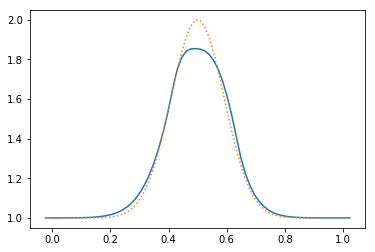

In [13]:
gr = mol_update(C, u, nx, num_periods=1.0, init_cond="gaussian")

plt.plot(gr.x, gr.a)
plt.plot(gr.x, gr.ainit, ls=":")

But for the tophat, we should get rid of the oscillations

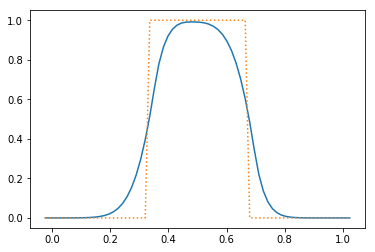

In [14]:
gr = mol_update(C, u, nx, num_periods=1.0, init_cond="tophat")

plt.plot(gr.x, gr.a)
plt.plot(gr.x, gr.ainit, ls=":")

<div style="background-color: powderblue; color: black; padding: 10px;">


**c.** Measure the convergence of your solver.  Since the linear advection
  equation should not change after one period, you can compute the 
  error after advecting as:
  \begin{equation}
    \epsilon = \| a_\mathrm{final} - a_\mathrm{initial} \|
  \end{equation}
  where $\| . \|$ is a norm, as discussed in class, and final and
  initial refer to the solution after one period and the initial
  conditions, respectively.

  Plot $\epsilon$ vs. $\Delta x$ on a log-log plot for several values
  of $\Delta x$ for both the tophat and Gaussian, using the slope
  limited method from part **b**.

In [15]:
Ns = [16, 32, 64, 128, 256, 512, 1024]
err_gauss = []
err_tophat = []
for nx in Ns:
    gr = mol_update(C, u, nx, num_periods=1.0, init_cond="tophat")
    err_tophat.append(gr.norm(gr.a - gr.ainit))

    gr = mol_update(C, u, nx, num_periods=1.0, init_cond="gaussian")
    err_gauss.append(gr.norm(gr.a - gr.ainit))
    

(0.001, 1)

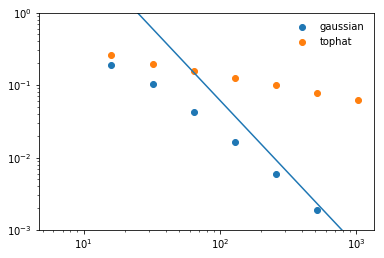

In [16]:
plt.scatter(Ns, err_gauss, label="gaussian")
plt.scatter(Ns, err_tophat, label="tophat")

# plot a trend line
N = np.asarray(Ns)
err = np.asarray(err_gauss)
plt.plot(N, err[-1]*(N[-1]/N)**2)
         
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(frameon=False)
plt.ylim(1.e-3, 1)

<div style="background-color: powderblue; color: black; padding: 10px;">

3. _Nonlinear hyperbolic equations_  In this problem we look
  at several first-order finite-difference methods for Burger's
  equation:
\begin{equation}
\label{burger1}
u_t + u u_x = 0
\end{equation}
This is a nonlinear equation.  
In conservative form, this appears as
\begin{equation}
\label{burger2}
u_t + \left [ \frac{1}{2} u^2 \right ]_x = 0
\end{equation}
Although these forms are analytically equivalent, the numerical solutions
will differ.
</div>

<div style="background-color: powderblue; color: black; padding: 10px;">

**a.** Using first-order upwinding, we can difference
the first form as
\begin{equation}
u_{i}^{n+1} = u_i^n - \frac{\Delta t}{\Delta x} u_i^n (u_i^n - u_{i-1}^n)
\end{equation}
This is valid as long as $u_i^n > 0$.  Write a program to solve this
equation with initial conditions:
\begin{equation}
u(x,t=0) = \bigg \{ \begin{array}{cc} 2 & \mathrm{if~} x < 0.5 \\
                                      1 & \mathrm{if~} x \ge 0.5 \\
                    \end{array}
\end{equation}
and outflow boundary conditions.  What type of solution do you see?
Also run it with:
\begin{equation}
u(x,t=0) = \bigg \{ \begin{array}{cc} 1 & \mathrm{if~} x < 0.5 \\
                                      2 & \mathrm{if~} x \ge 0.5 \\
                    \end{array}
\end{equation}
Now what does the solution look like?

<p>Important: This is a non-linear equation---make sure you use the
proper CFL condition for this method.  This means: pick a value for $C$,
then evaluate $\Delta t = C \Delta x / \max_i\{u\}$
</div>

Here's our grid class.  It is much like that in problem 1, except for the treatment of the boundary conditions.

In [17]:
class CCFDgrid(object):

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.u = self.scratch_array()
        self.uinit = self.scratch_array()

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the a single ghostcell with Neuamnn BCs """
        self.u[self.ilo-1] = self.u[self.ilo]
        self.u[self.ihi+1] = self.u[self.ihi]

<div style="background-color: powderblue; color: black; padding: 10px;">
**b.** Now difference the second form as
\begin{equation}
u_{i}^{n+1} = u_i^n - \frac{\Delta t}{\Delta x} \left ( \frac{1}{2} (u_i^n)^2 
 - \frac{1}{2} (u_{i-1}^n)^2 \right )
\end{equation}
Write a program to solve this, and run it on the same initial data as
in part {\bf a}.  Note that both of these discretizations assume that
$u > 0$.

<p>How do the solutions differ for the two discretizations?  One of the
initial conditions generates a shock---measure its speed for each
method.  How does the shock speed differ with resolution?  Which
method gets the shock speed correct?  Why? Present your results at 3
different grid resolutions.

We'll write the solvers for parts **a** and **b** in a single routine:

In [18]:
def evolve(nx, C, tmax, conservative=True, init="shock"):

    ng = 1

    # create the grid
    g = CCFDgrid(nx, ng)

    # initial conditions
    if init == "shock":
        g.u[:] = 1.0
        g.u[g.x < 0.5] = 2.0

    elif init == "rarefaction":
        g.u[:] = 1.0
        g.u[g.x > 0.5] = 2.0


    t = 0.0

    # fill the boundary conditions
    g.fill_BCs()

    g.uinit[:] = g.u[:]

    # evolution loop
    unew = g.scratch_array()

    while t < tmax:

        # timestep
        dt = C*g.dx/max(g.u[g.ilo:g.ihi+1])

        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # loop over zones
        for i in range(g.ilo, g.ihi+1):
            if conservative:
                unew[i] = g.u[i] - dt*(0.5*g.u[i]**2 - 0.5*g.u[i-1]**2)/g.dx
            else:
                unew[i] = g.u[i] - dt*g.u[i]*(g.u[i] - g.u[i-1])/g.dx

        # store the updated solution
        g.u[:] = unew[:]

        # fill the boundary conditions
        g.fill_BCs()

        t += dt

    return g

Now... we'll look at the rarefaction stuff together

In [19]:
def rarefaction_test(nx, C=0.5):
    """compare the conservative and non-conservative method on the
    rarefaction initial conditions"""

    plt.clf()

    tmax1 = 0.3

    gc = evolve(nx, C, tmax1, conservative=True, init="rarefaction")
    gnc = evolve(nx, C, tmax1, conservative=False, init="rarefaction")

    plt.plot(gc.x[gc.ilo:gc.ihi+1], gc.u[gc.ilo:gc.ihi+1],
             color="C0", label="conservative")
    plt.plot(gnc.x[gnc.ilo:gnc.ihi+1], gnc.u[gnc.ilo:gnc.ihi+1],
             color="C1", label="non-conservative")


    tmax0 = 0.1

    gc = evolve(nx, C, tmax0, conservative=True, init="rarefaction")
    gnc = evolve(nx, C, tmax0, conservative=False, init="rarefaction")

    plt.plot(gc.x[gc.ilo:gc.ihi+1], gc.u[gc.ilo:gc.ihi+1],
             color="C0", ls="--")
    plt.plot(gnc.x[gnc.ilo:gnc.ihi+1], gnc.u[gnc.ilo:gnc.ihi+1],
             color="C1", ls="--")


    plt.plot(gnc.x, gc.uinit, color="0.5", label="initial conditions")

    plt.xlim(0,1)

    plt.legend(frameon=False, fontsize="small")

    plt.xlabel("x")
    plt.ylabel("u")

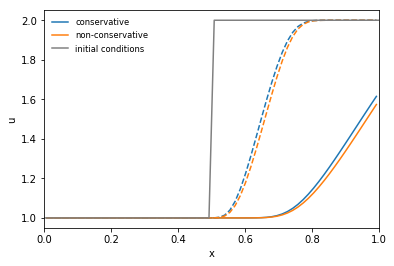

In [20]:
rarefaction_test(64)

and the shock initial conditions.  We'll do a finite-difference to find the shock speeds.  We know the analytic value of the shock speed,
$$S = \frac{1}{2}(u_l + u_r)$$
Which is 1.5 for our initial conditions.

In [21]:
def shock_test(nx, C=0.5):
    """compare the conservative and non-conservative method on the
    shock initial conditions"""

    # analytic shock speed
    S = 0.5*(1.0 + 2.0)

    tmax1 = 0.3

    plt.clf()

    gc = evolve(nx, C, tmax1, conservative=True, init="shock")
    gnc = evolve(nx, C, tmax1, conservative=False, init="shock")

    # find the position of the shock and interpolate to find the x
    idx = np.nonzero(gnc.u < S)[0][0]
    m = (gnc.u[idx] - gnc.u[idx-1])/(gnc.x[idx] - gnc.x[idx-1])
    x_shk1 = gnc.x[idx] + (S - gnc.u[idx])/m

    plt.plot(gc.x[gc.ilo:gc.ihi+1], gc.u[gc.ilo:gc.ihi+1],
             color="C0", label="conservative")
    plt.plot(gnc.x[gnc.ilo:gnc.ihi+1], gnc.u[gnc.ilo:gnc.ihi+1],
             color="C1", label="non-conservative")

    # analytic shock position, assuming u_l = 2, u_r = 1, and initial
    # discontinuity at 0.5
    plt.plot([S*tmax1 + 0.5, S*tmax1 + 0.5], [1,2],
             color="0.5", ls=":", label="analytic shock position")


    tmax0 = 0.1

    gc = evolve(nx, C, tmax0, conservative=True, init="shock")
    gnc = evolve(nx, C, tmax0, conservative=False, init="shock")

    idx = np.nonzero(gnc.u < S)[0][0]
    m = (gnc.u[idx] - gnc.u[idx-1])/(gnc.x[idx] - gnc.x[idx-1])
    x_shk0 = gnc.x[idx] + (S - gnc.u[idx])/m


    # compute the shock speed via differencing
    S_numerical = (x_shk1 - x_shk0)/(tmax1 - tmax0)

    print("shock speeds: {}, {}, {}".format(S_numerical, S, S_numerical - S))


    plt.plot(gc.x[gc.ilo:gc.ihi+1], gc.u[gc.ilo:gc.ihi+1],
             color="C0", ls="--")
    plt.plot(gnc.x[gnc.ilo:gnc.ihi+1], gnc.u[gnc.ilo:gnc.ihi+1],
             color="C1", ls="--")

    plt.plot(gnc.x, gc.uinit, color="0.5", label="initial conditions")

    plt.xlim(0,1)

    plt.legend(frameon=False, fontsize="small")

    plt.xlabel("x")
    plt.ylabel("u")


shock speeds: 1.4061502142973654, 1.5, -0.09384978570263458


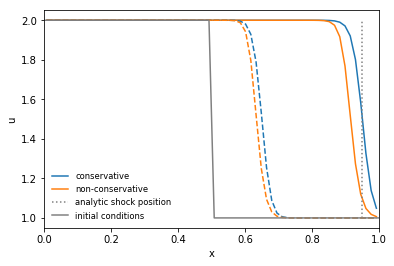

In [22]:
shock_test(64)

Notice that the conservative method gets the shock speed correct, while the non-conservative version does not.